## Coding Exercise #0707

### 1. Convolutional Neural Network (color images):

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.datasets.cifar10 import load_data
import matplotlib.pyplot as plt

%matplotlib inline

#### 1.1. Download the data:

More information about the dataset can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

In [2]:
(X_train, y_train), (X_test, y_test) = load_data()
n_train_size = X_train.shape[0]

170498071/170498071 [==============================] - 4s 0us/step


#### 1.2. Take a look at the dataset:

In [3]:
# Images already reshaped as 32x32.
# 3 Color channels.
# y is not one-hot-encoded yet.
print("Training data X shape: {}".format(X_train.shape))
print("Training data y shape: {}".format(y_train.shape))
print("\n")
print("Testing data X shape: {}".format(X_test.shape))
print("Testing data y shape: {}".format(y_test.shape))

Training data X shape: (50000, 32, 32, 3)
Training data y shape: (50000, 1)


Testing data X shape: (10000, 32, 32, 3)
Testing data y shape: (10000, 1)


Visualization.

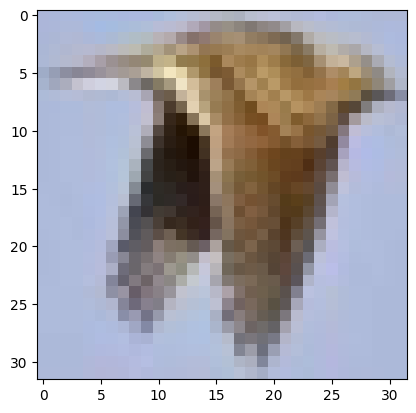

In [4]:
i_image= 123                                                        # Image index. You can change it at will.
a_single_image= X_train[i_image,:,:,:]
plt.imshow(a_single_image)                                          #  Display as a color image.
plt.show()

In [5]:
# Check for the minimum and maximum pixel value.
print("MIN : {}".format(a_single_image.min()))
print("MAX : {}".format(a_single_image.max()))

MIN : 1
MAX : 243


#### 1.3. Data preprocessing:

In [6]:
# Scaling.
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [7]:
# One-Hot-Encoding.
y = np.concatenate([y_train[:,0],y_test[:,0]],axis=0)
y = np.array(pd.get_dummies(y, drop_first=False))                   # drop_frist = False for one-hot-encoding.
y_train = y[:n_train_size,:]
y_test = y[n_train_size:,:]

#### 1.4. Define the hyperparameters:

In [8]:
batch_size = 8
n_epochs  = 50001
learn_rate = 0.0001
drop_prob = 0.5                                                     # For the dropout layer.

#### 1.5. Define the Variables:

The configuration of the first convolution layer is as following:
- Kernel height = 7.
- Kernel width = 7.
- In_chanels = **3 (color)**.
- Out_channels = 32 (number of feature maps).

We need Variables with the folllowing shapes:
- Shape of the weight matrix = [kernel_height, kernel_width, in_channels, out_channels].
- Shape of the bias = [out_channels].

In [10]:
# Variables are defined according to the specifications mentioned above.
W1 = tf.Variable(initial_value=tf.random.normal([7,7,3,32], mean=0, stddev=0.1))
b1 = tf.Variable(initial_value=tf.fill([32], 0.1))

The configuration of the second convolution layer is as following:
- Kernel height = 7.
- Kernel width = 7.
- In_chanels = 32 (out_channels from the previous convolution layer).
- Out_channels = 64 (number of feature maps).

Again, we need Variables with the folllowing shapes:
- Shape of the weight matrix = [kernel_height, kernel_width, in_channels, out_channels].
- Shape of the bias = [out_channels].

In [11]:
# Variables are defined according to the specifications mentioned above.
W2 = tf.Variable(initial_value=tf.random.normal([7,7,32,64], mean=0, stddev=0.1))
b2 = tf.Variable(initial_value=tf.fill([64], 0.1))

We do the following considerations for the flattened fully connected layer:
- We will apply convolution twice with padding and there will be no image size reduction.
- We will also apply max pooling twice with stride = 2 (vertically and horizontally).
- At each max pooling with stride = 2, the image size is halved. Thus, **(32/2)/2 = 8** will be the size (vertical and horizontal) of the resulting final image.   
- In the previous layer there were 64 output channels (feature maps).
- Considering all these facts, there should be **8x8x64 = 4096** nodes in the flattened layer.
- Finally, we will shrink the output from this layer to 1024.

In [12]:
# Variables are defined according to the specifications mentioned above.
W3 = tf.Variable(initial_value=tf.random.normal([4096,1024], mean=0, stddev=0.1))
b3 = tf.Variable(initial_value=tf.fill([1024], 0.1))

We do the following considerations for the final output layer:
- There are 1024 nodes to match with the output from the previous layer.
- We should shrink the output once more because there are 10 different labels (digits 0~9).

In [13]:
# Variables are defined according to the specifications mentioned above.
W4 = tf.Variable(initial_value=tf.random.normal([1024,10], mean=0, stddev=0.1))
b4 = tf.Variable(initial_value=tf.fill([10], 0.1))

#### 1.6. Define the deep learning model (CNN):

Explanation of the arguments:
- padding = 'SAME' to apply a padding. padding = 'VALID' to apply no padding.
- ksize = [1, kernel_height, kernel_width, 1]
- strides = [1, stride_vertical, stride_horizontal,1]

In [14]:
def model(X, drop_probability):
  # 1st Convolution layer.
  y1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME') + b1
  conv1 = tf.nn.relu(y1)                            # Apply the ReLu activation function.
  # 1st Pooling layer.
  pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

  # 2nd Convolution layer.
  y2 = tf.nn.conv2d(pool1, W2, strides=[1, 1, 1, 1], padding='SAME') + b2
  conv2 = tf.nn.relu(y2)                            # Apply the ReLu activation function.
  # 2nd Pooling layer.
  pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

  # Flattened full layer.
  conv2_flattened = tf.reshape(pool2, [-1,4096])    # 8x8x64 = 4096.
  y3 = tf.matmul(conv2_flattened, W3) + b3
  full_layer = tf.nn.relu(y3)                       # Apply the ReLu activation function.

  # Dropout layer.
  dropout_layer = tf.nn.dropout(full_layer, rate = drop_probability)

  # Output layer.
  y_model = tf.matmul(dropout_layer, W4) + b4       # No activation function. Softmax at the output layer is optional.
  return y_model

#### 1.7. Define the loss function and the optimizer:

In [15]:
def loss_fn(y_true, y_pred):
  return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

In [16]:
optimizer = tf.optimizers.Adam(learning_rate = learn_rate)

#### 1.8. Training and Testing:

In [17]:
@tf.function
def train_step(X, y, drop_probability):
    with tf.GradientTape() as tape:
        y_pred = model(X, drop_probability)
        loss = loss_fn(y, y_pred)
    gradients = tape.gradient(loss, [W1, W2, W3, W4, b1, b2, b3, b4])
    optimizer.apply_gradients(zip(gradients, [W1, W2, W3, W4, b1, b2, b3, b4]))

# Training.
for i in range(n_epochs):
    idx_rnd = np.random.choice(range(n_train_size), batch_size, replace=False)                          # Random sampling w/o replacement for the batch indices.
    batch_X, batch_y = [X_train[idx_rnd, :], y_train[idx_rnd, :]]                                       # Sample a batch!
    train_step(batch_X, batch_y, drop_prob)
    # Testing.
    if i % 500 == 0:
        correct_predictions = tf.equal(tf.argmax(y_test, axis=1), tf.argmax(model(X_test,0), axis=1))   # In argmax(), axis=1 means horizontal direction. No dropout for testing.
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))                             # Recast the Boolean as float32 first. Then calculate the mean.
        accuracy_value = accuracy.numpy()
        print("Step = {}   ,   Accuracy = {:5.3f}".format(i, accuracy_value))

Step = 0   ,   Accuracy = 0.096
Step = 500   ,   Accuracy = 0.252
Step = 1000   ,   Accuracy = 0.281
Step = 1500   ,   Accuracy = 0.323
Step = 2000   ,   Accuracy = 0.345
